#### PRELIMINARIES

**NB this notebooks runs in Python 3.6**

In [1]:
# Import main libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import numpy as np
import scipy as sp
import seaborn as sns

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

#### FUNCTION TO MAKE A PREDICTION ERROR LOG / FLAG

The function below calculates the difference between a predicted and a target curve and flags differences based on a user-defined distance (in standard deviation units) from the mean difference.

**NB it is now in Bruge's Petrophysics module**

From MyCarta's  [Geoscience_ML_notebook 6](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_6.ipynb).


Method 1: difference between curves larger than mean difference plus/minus 1 std

Future work
- Method 2: curve slopes have opposite sign
- Method 3: opposite sign OR difference larger than mean plus 1 std

In [2]:
def error_flag(pred, actual, dev=1, method=1):
    """Make error flag using three methods"""
    
     ###### input ######
    
    # predicted = predicted log
    
    # actual =  original log
    
    # method 1: difference between logs larger than mean difference plus 1 std
    # method 2: slopes have opposite sign.
    # method 3: opposite sign OR difference larger than mean plus 1 std
    

    ###### output ######
    
    # flag =  error flag
    
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
     
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
   
    return flag

#### IMPORT DATA FOR FIRST EXAMPLE

I will use the result from Alessandro Amato del Monte's [Inverse Gardner Notebook](https://github.com/aadm/geophysical_notes/blob/master/inverse_gardner.ipynb), where he shows how to econstruct a velocity log from density log using optimized alpha and beta parameters for his inverse gardner function, found via `scipy.curve_fit`.

In [3]:
logs1 = pd.read_csv('../data/aadm_gardner.csv')
logs1.describe()

,depth,gr,vp_hole,vp_no_hole,vp_gardner,vp_rebuilt
count,4117.000000,4117.000000,3789.000000,4117.000000,328.000000,4117.000000
mean,2326.892000,72.785125,3037.046267,2984.389630,2361.049371,2983.189822
std,181.145666,14.464120,423.877490,444.671505,51.245128,446.180764
min,2013.252800,48.368700,1439.900000,1439.900000,2238.841631,1439.900000
25%,2170.072500,60.683100,2736.700000,2611.300000,2322.305286,2609.000000
50%,2326.892100,68.026600,3074.800000,3038.158346,2356.921449,3038.158346
75%,2483.711700,83.557200,3263.700000,3251.100000,2403.044013,3251.100000
max,2640.531200,136.512800,4431.000000,4431.000000,2515.005238,4431.000000


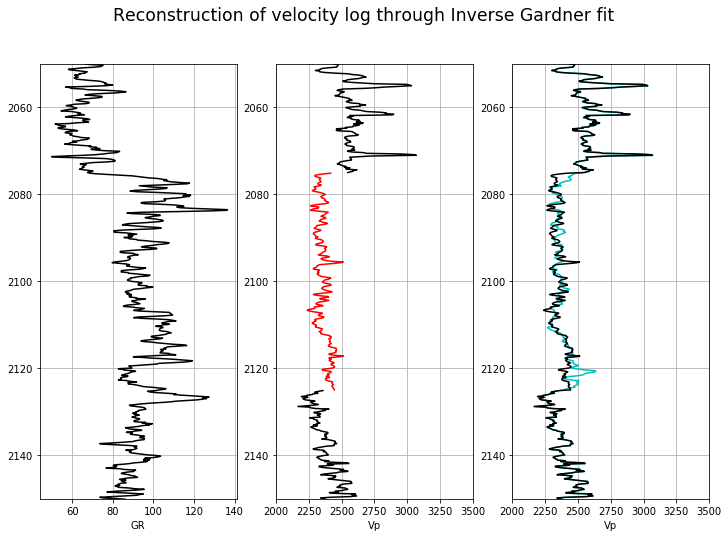

In [4]:
fig,ax = plt.subplots(1,3,figsize=(12,8))
ax[0].plot(logs1.gr,logs1.depth,'-k')
ax[0].set_xlabel('GR')
ax[1].plot(logs1.vp_hole,logs1.depth,'-k')
ax[1].plot(logs1.vp_gardner,logs1.depth,'-r')
ax[1].set_xlabel('Vp')
ax[1].set_xlim(2000,3500)
ax[2].plot(logs1.vp_no_hole,logs1.depth,'-c')
ax[2].plot(logs1.vp_rebuilt,logs1.depth,'-k')
ax[2].set_xlabel('Vp')
ax[2].set_xlim(2000,3500)
for aa in ax:
    aa.set_ylim(2150,2050)
    aa.grid()
plt.suptitle('Reconstruction of velocity log through Inverse Gardner fit', fontsize='xx-large');

In the figure above, reproduced from Alessandro's notebook, the velocity log with the missing data is displayed together with the reconstructed portion (respectively black and red curves in the middle plot), and also a comparison between the fully-rebuilt velocity log (rightmost plot, black curve) and the original log as it was recorded before artificially creating a gap in it (cyan curve).

In [22]:
np.where((logs1['depth'][(logs1['depth'] > 2075) | (logs1['depth'] < 2075)]))

(array([   0,    1,    2, ..., 4114, 4115, 4116], dtype=int64),)

In [16]:
hole=(logs1.depth>2075) & (logs1.depth<2125)
hole

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
4087    False
4088    False
4089    False
4090    False
4091    False
4092    False
4093    False
4094    False
4095    False
4096    False
4097    False
4098    False
4099    False
4100    False
4101    False
4102    False
4103    False
4104    False
4105    False
4106    False
4107    False
4108    False
4109    False
4110    False
4111    False
4112    False
4113    False
4114    False
4115    False
4116    False
Name: depth, Length: 4117, dtype: bool

In [20]:
hole=((logs1.depth>2075) & (logs1.depth<2125))
#hole=(logs1['depth'][(logs1['depth'] > 2075) | (logs1['depth'] < 2075)]).values
print(np.amin(hole), np.amax(hole))
flag = np.zeros(len(logs1.vp_rebuilt))
print(len(flag))
flag[hole] = error_flag(logs1.vp_rebuilt[hole], logs1.vp_no_hole[hole],  0.5)
print(len(flag))

False True
4117
4117


C:\ProgramData\Anaconda3_mnicc\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  
C:\ProgramData\Anaconda3_mnicc\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  


C:\ProgramData\Anaconda3_mnicc\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


ValueError: operands could not be broadcast together with shapes (4117,) (328,) 

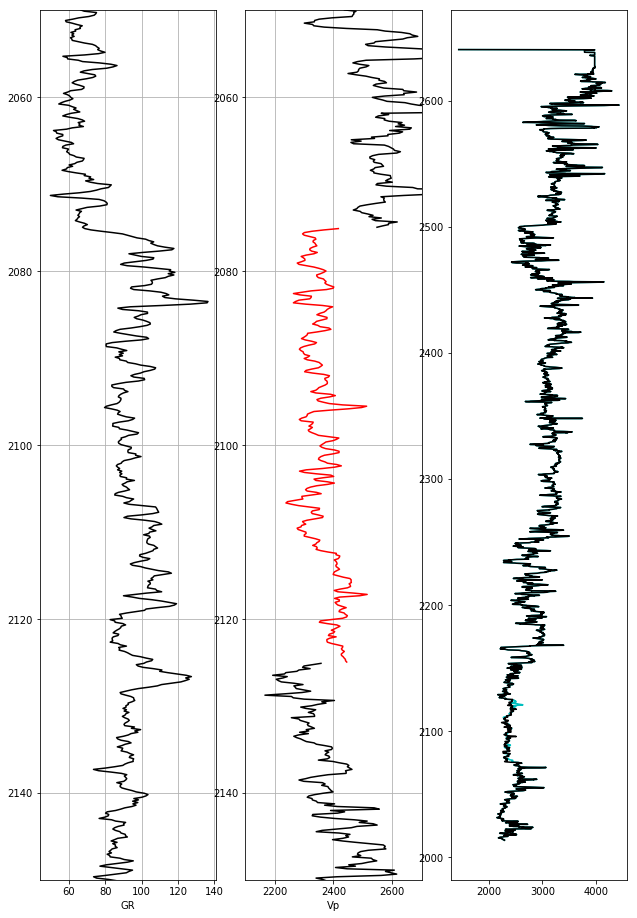

In [21]:
mi = 2100
ma = 2700
fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.3]) 

ax = plt.subplot(gs[0])
ax.plot(logs1.gr, logs1.depth,'-k')
ax.set_xlabel('GR')
ax.set_ylim(2150,2050)
ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs1.vp_hole, logs1.depth,'-k')
ax1.plot(logs1.vp_gardner, logs1.depth,'-r')
ax1.set_xlabel('Vp')
ax1.set_xlim(mi, ma)
ax1.set_ylim(2150,2050)
ax1.grid()

ax2 = plt.subplot(gs[2])
ax2.plot(logs1.vp_no_hole, logs1.depth,'-c')
ax2.plot(logs1.vp_rebuilt, logs1.depth,'-k')
ax2.fill_betweenx(logs1.depth[hole], logs1.vp_no_hole[hole],  logs1.vp_rebuilt[hole], where=flag[hole]==1,   color = 'r', label='error flag')
ax2.set_xlabel('Vp')
ax2.set_xlim(mi, ma)
ax2.set_ylim(2150,2050)
ax2.grid()

ax3 = plt.subplot(gs[3])
ax3.fill_betweenx(logs1.depth[hole], flag[hole], 0, color = 'r')
ax3.invert_yaxis()
ax3.invert_xaxis()
ax3.set_xlabel('error flag')
ax3.set_ylim(2150,2050)
ax3.grid()

This figure is the same as above but now there is an extra track with the error flag on the right, and I also added fill between the predicted and reconstructed original according to the flag.

#### IMPORT DATA FOR SECOND EXAMPLE

I will use the latest result from my [Geoscience ML notebook 6](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_6.ipynb). This is an evolving notebook in which I evaluate and compare the performance of different ML methods in predicting a geophysical log from a suite of other logs. THe current result is prediction of compressional sonic log using a linear model and the Gamma Ray, Neutron Porosity, and Bulk Density logs.

In [ ]:
logs2 = pd.read_csv('../data/logs2.csv')
logs2.describe()

Original versus predicted sonic, as scatter plots.

In [ ]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs2["predictedVP"], logs2["DEPTH"], s = 3, color = 'b')
ax1.scatter(logs2["VP"], logs2["DEPTH"], s = 3, color = 'gray', alpha = 0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Original versus predicted sonic, as scatter plot mimicking lines.

In [ ]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)
ax1.plot( logs2["predictedVP"], logs2["DEPTH"],'b')
ax1.plot( logs2["VP"], logs2["DEPTH"],'gray', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
flag = error_flag(logs2["predictedVP"], logs2["VP"], 1,  1)

In [ ]:
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=18)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=18)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=18)

ax1.legend()
    
ax1.grid()
#fig.savefig('file.png', dpi=250, bbox_inches='tight', pad_inches=0.2)
plt.show()


#### ADD A RESERVOIR FLAG

Load compilation of tops. Source:

http://factpages.npd.no/FactPages/Default.aspx?nav1=wellbore&nav2=PageView|Exploration|All&nav3=2635&culture=en

In [ ]:
tops = pd.read_csv('../data/qsi_well2_tops.csv')
tops

Get reservoir top and bottom depths

In [ ]:
top1 = np.float64(tops.loc[tops['name']=='HEIMDAL', ['depth']].values[0]) # top of Heimdal sand
top2 = np.float64(tops.loc[tops['name']=='OWC', ['depth']].values[0]) # Oil-Water Contact
#print(top1, top2)

In [ ]:
oil = np.zeros(len(logs2["DEPTH"]))
logs2['oil_zone']=oil
logs2.loc[(logs2["DEPTH"]>top1) & (logs2["DEPTH"]<top2), 'oil_zone']= 1
logs2.describe(include='all')

In [ ]:
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(1, 3, width_ratios=[0.5,0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=14)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=14)
ax.grid()

ax1 = plt.subplot(gs[2])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.set_xlim((2000, 4500))
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')


ax2 = plt.subplot(gs[1])
ax2.fill_betweenx(logs2['DEPTH'],  0, logs2['oil_zone'],  color = 'gold')
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_yticks([])
ax2.set_xlabel('reservoir', size=14)
ax2.grid()

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=18)

ax1.legend()
    
ax1.grid()
#fig.savefig('file.png', dpi=250, bbox_inches='tight', pad_inches=0.2)
plt.show()


#### CALCULATING ERROR STATISTICS BY STRATIGRAPHYC UNIT IF ZONE LOG IS PROVIDED

Future work:  make zone log directly from tops



**NB HAVE NOT BUILT A TEST YET FOR THESE TWO METHODS**

In [ ]:
logs2.describe(include='all')

In [ ]:
zones = list(logs2['ZONE_NUM'].unique())
zones

In [ ]:
mean_abs_err = [np.mean(np.abs(logs2.loc[logs2.ZONE_NUM ==z, 'predictedVP'] 
                               -logs2.loc[logs2.ZONE_NUM ==z, 'VP'])) for z in zones]
mean_abs_err = np.array(mean_abs_err)
print(mean_abs_err)

In [ ]:
def zone_thickness(d, zone):
    """ returns amount of flagged portion of a zone"""
    #### input ####
    # d= depth log (e.g. logs['DEPT'])
    # zone = stratigraphic zone (e.g. 1 = D1)
    
    th = np.amax(d[np.where(logs2['ZONE_NUM']== zone)]) - np.amin(d[np.where(logs2['ZONE_NUM']== zone)])

    return th

In [ ]:
thicknesses =  np.array([zone_thickness(np.array(logs2['DEPTH']), z)  for z in zones])
thicknesses